# Simulation of ratial sampling

Import the required libraries and the image data

In [2]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)
print(t1.shape)

(90, 256, 256)


We use the middle slice.

When using `sigpy.plot.ImagePlot`, the rows are flipped, so we compensate for this when plotting the image

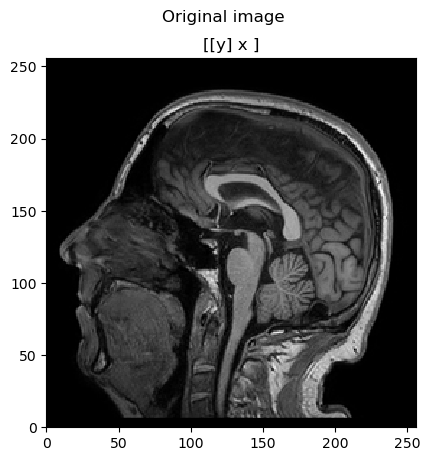

In [5]:
img_original = t1[45]
sigpy.plot.ImagePlot(sigpy.flip(img_original,axes=(2,)),title='Original image')

Generate the foordinates where the k-space will be sampled using `sigpi.mri.radial`. Contraty to what is shown in the project instructions, the spokes don't go across the origin, but rather, they expand from the origin, starting at the positive y-axis and turning clockwise for each consecutive spoke. Since the instructions give a spoke of 256 samples across the origin, we generate our spokes having 128 samples from the origin. To begin with, we acquire 180 spokes, equivalent to 90 of the spokes assumed in the project instructions.

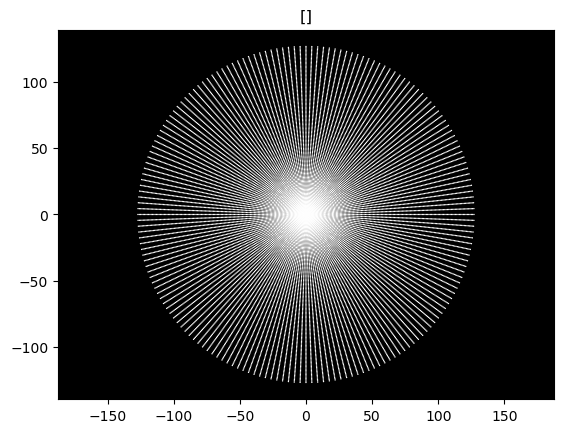

In [7]:
coord = sigpy.mri.radial([180,128,2],[256,256],golden=False)
sigpy.plot.ScatterPlot(coord)

Since the spokes are generated with the origin in the middle, but the image is an array whose pixel at (0,0) lies on the top left corner, we need to translate the spokes set to the center of the image. For this we have created a function to translate the spokes set to the middle pixel of any image:

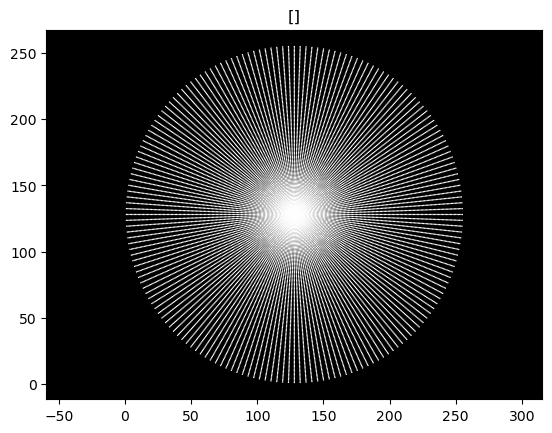

In [8]:
def translate_spokes_to_img_coord(spokes, im_size=(256,256)):
    x_shift = np.floor(im_size[1]/2) # x_shift determines how columns will be shifted
    y_shift = np.floor(im_size[0]/2) # y_shift determines how rows will be shifted
    new_spokes = []
    for spoke in spokes:
        new_spoke = []
        for point in spoke:
            new_point = [point[0] + x_shift, abs(point[1] - y_shift)]
            new_spoke.append(new_point)
        new_spokes.append(new_spoke)
    return np.array(new_spokes)

coord = translate_spokes_to_img_coord(coord)
sigpy.plot.ScatterPlot(coord)

Now we obtain the density compensation factor for the k-space

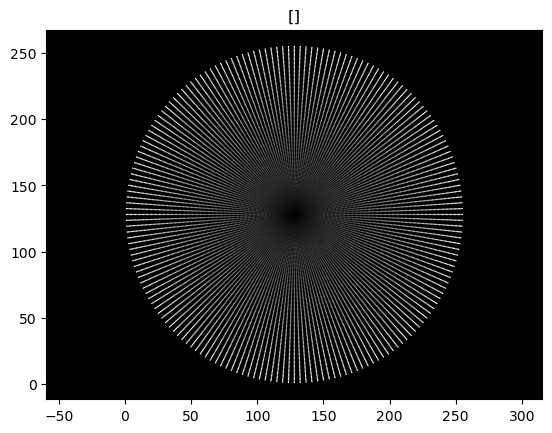

In [12]:
dcf = ((coord[...,0]-128)**2+(coord[...,1]-128)**2)**0.5
sigpy.plot.ScatterPlot(coord,dcf)

We obtain the fourier transform of the image (k-space) and sample it with the coordinates we acquired previously using the sigpy functions `fft` and `interpolate`

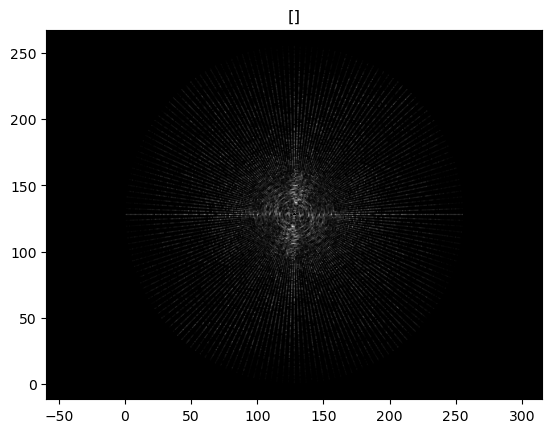

In [17]:
img_ksp = sigpy.fft(img_original)
sampled_ksp = sigpy.interpolate(img_ksp,coord)
sampled_ksp_compensated = sampled_ksp*dcf
sigpy.plot.ScatterPlot(coord,sampled_ksp_compensated)

In [ ]:
img_reconstructed = sigpy.nufft_adjoint(ksp